# JLD2 to CSV
This script convets `.jld2` files output from `PorousMaterials.jl`'s `gcmc_simulation` function and compiles them into a `.csv` file which can then be imported into a DataFrame.

In [33]:
using PorousMaterials
using FileIO
# using JLD2
using CSV
using DataFrames
using PyPlot

PyPlot.matplotlib.style.use("grandbudapest.mplstyle") # uses style
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

**TODO:**
* consider renaming to "gcmc_results_to_dataframe" 
* should we have this write the dataframe file directly to the gcmc_sims directory?
* make input arguements iinto a dictionary (possibly accept as commandline arguments)

In [58]:
pressures = 10 .^ range(-2, stop=log10(300), length=15)
frameworks = ["NiPyC2", "SBMOF-1","COF-103_simulated"]
PorousMaterials.PATH_TO_DATA

"Z:\\.julia\\dev\\PropellantStorage\\data"

In [50]:
"""
dataframe = isotherm_sim_results_to_dataframe(desired_props, 
    framework_name, adsorbate, forcefield_name, temperature,
    pressures, n_burn_cycles, n_sample_cycles;
    where_are_jld_files=nothing)

Convert the `.jld2` results output files from GCMC into a DataFrame 
for a specifies set of desired properties. 

# Arguments
- `desired_props::Array{String}`: 
- `framework_name::String`: The porous crystal that was tested
- `adsorbate::Symbol`: The molecule that was tested inside the porous crystal  
- `forcefield_name::String`: The molecular model being used in the simulation to describe intermolecular Van
        der Waals interactions
- `temperature::Float64`: The temperature used in the simulation, units: Kelvin (K)
- `pressures::Array{Float64}`: The pressure used in the simulation(s), units: bar 
- `n_burn_cycles::Int`: The number of burn cycles used in this simulation
- `n_sample_cycles::Int`: The number of sample cycles used in the simulations
- `where_are_jld_files::Union{String, Nothing}=nothing`: The location to the simulation files

# Returns
- `dataframe::DataFrame`: A DataFrame containing the data for the specified properties

# Note 
A range of pressures can be used to select a batch of simulation files to be included in the DataFrame.

# Example
dataframe = isotherm_sim_results_to_dataframe(["pressure (bar)", "⟨N⟩ (mmol/g)"],
    "COF-102", :Xe, "UFF", 298.0, 
    10 .^ range(-2, stop=log10(300), length=15),
    25000, 25000)
"""
function isotherm_sim_results_to_dataframe(desired_props::Array{String},
        framework_name::String, adsorbate::Symbol, forcefield_name::String, temperature::Float64, 
        pressures::Array{Float64}, n_burn_cycles::Int, n_sample_cycles::Int; 
        where_are_jld_files::Union{String, Nothing}=nothing)
    # determine the location of the data files
    if isnothing(where_are_jld_files)
        where_are_jld_files = joinpath(PorousMaterials.PATH_TO_DATA, "gcmc_sims")
    end
    # prepare dataframe to populate
    df = DataFrame()
    for col in desired_props
        insertcols!(df, length(names(df)) + 1, Symbol(col) => Float64[])
    end
    for (i, pressure) in enumerate(pressures)
        sim_result = load(
            joinpath(where_are_jld_files, 
                gcmc_result_savename(framework_name, adsorbate, forcefield_name, 
                    temperature, pressure, n_burn_cycles, n_sample_cycles) * ".jld2"
            ), "results"
        )
        push!(df, [sim_result[prop] for prop in desired_props])
    end
    return df
end

isotherm_sim_results_to_dataframe

In [59]:
sim_to_isotherm = Dict{String, DataFrame}() # must be defined outside of the function if you want to plot

props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]
for frameworkname in frameworks
    sim_to_isotherm[frameworkname] = isotherm_sim_results_to_dataframe(props_we_want, frameworkname,
        :Xe, "UFF", 298.0, pressures, 25000, 25000)
   # CSV.write(joinpath("data", "sim_xe_isotherms", frameworkname * "_high_P.csv"), sim_to_isotherm[frameworkname])
end
sim_to_isotherm

Dict{String,DataFrame} with 3 entries:
  "NiPyC2"            => 15×3 DataFrame…
  "SBMOF-1"           => 15×3 DataFrame…
  "COF-103_simulated" => 15×3 DataFrame…

In [60]:
sim_to_isotherm["COF-103_simulated"]

,pressure (bar),fugacity (bar),⟨N⟩ (mmol/g)
,Float64,Float64,Float64
1,0.01,0.0099994,0.0154965
2,0.0208831,0.0208804,0.0320775
3,0.0436103,0.0435988,0.067746
4,0.0910716,0.0910217,0.140109
5,0.190186,0.189968,0.29496
6,0.397166,0.396216,0.627677
7,0.829404,0.825266,1.3172
8,1.73205,1.71403,2.8646
9,3.61705,3.53872,6.2911


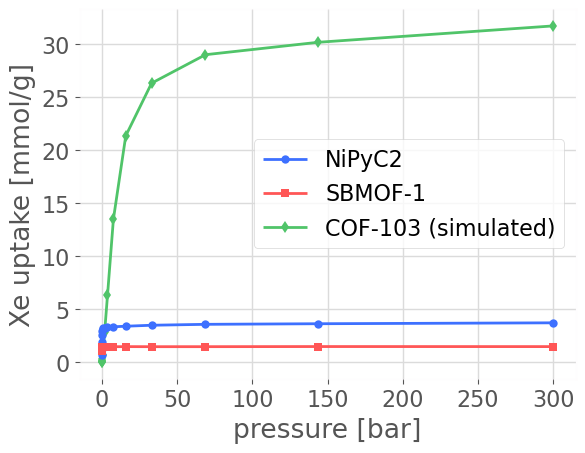

PyObject Text(36.000000000000014, 0.5, 'Xe uptake [mmol/g]')

In [53]:
figure()
sim_to_marker = Dict(zip(frameworks, ["o", "s", "d"]))
for sim in frameworks
    if sim == "COF-103_simulated"
        plot(sim_to_isotherm[sim][:, Symbol("pressure (bar)")], 
         sim_to_isotherm[sim][:, Symbol("⟨N⟩ (mmol/g)")], 
        label="COF-103 (simulated)", marker=sim_to_marker[sim])
    else
        plot(sim_to_isotherm[sim][:, Symbol("pressure (bar)")], 
         sim_to_isotherm[sim][:, Symbol("⟨N⟩ (mmol/g)")], 
        label=sim, marker=sim_to_marker[sim], zorder=500)
    end
end
legend()
xlabel("pressure [bar]")
ylabel("Xe uptake [mmol/g]")
#title("simulated Xe isotherm")

In [22]:
# figure()
# plot(cof_to_isotherm["COF-102"][:, Symbol("pressure (bar)")], cof_to_isotherm["COF-102"][:, Symbol("fugacity (bar)")], marker="o")
# plot([0, 300], [0, 300], color="k", linestyle="--")
# xlabel("pressure (bar)")
# ylabel("fugacity (bar)")
# title("fugacity versus pressure")

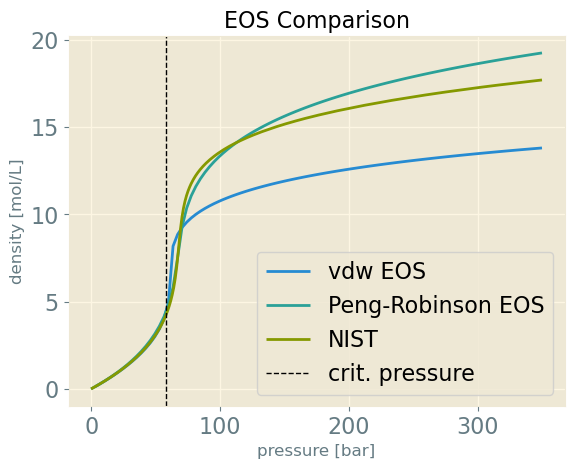

PyObject <matplotlib.legend.Legend object at 0x0000000001D445E0>

In [23]:
const xe_critical_pressure = 58.420 # bar
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)
p_plot = range(0.0, 350.0, length=100)
xe_vdw = VdWFluid(:Xe)
xe_pr = PengRobinsonFluid(:Xe)
ρ_vdw = [1.0 / calculate_properties(xe_vdw, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]
ρ_pr = [1.0 / calculate_properties(xe_pr, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]

figure()
plot(p_plot, ρ_vdw, label="vdw EOS")
plot(p_plot, ρ_pr, label="Peng-Robinson EOS")
plot(df_xe_data[!, Symbol("Pressure (bar)")], df_xe_data[!, Symbol("Density (mol/l)")], label="NIST")
axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)
xlabel("pressure [bar]")
ylabel("density [mol/L]")
title("EOS Comparison")
legend()

# savefig("xenon_gas_density.png", format="png")